In [2]:
%pip install matplotlib pysimilar --quiet


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import json
from matplotlib import pyplot as plt
from pysimilar import compare

answers_benchmark_path = "../answer_questions/results/benchmar_results_responses_2.json"
if not os.path.exists(answers_benchmark_path):
    raise FileNotFoundError("Please run the extraction benchmark first")
  
with open(answers_benchmark_path, "r") as file:
    data_answers = json.load(file)

# Answers

## Number of answered questions

In [4]:
emails = data_answers["results"]
num_questions = 0
for email in emails:
    num_questions += len(data_answers["results"][email])

num_answers = 0
for email in emails:
    for question in data_answers["results"][email]:
        sources = question["sources"]
        num_answers += 1 if len(sources) > 0 else 0
      

print(f"Number of questions: {num_questions}")
print(f"Number of answers: {num_answers}")

Number of questions: 34
Number of answers: 34


## Similarity scores

When the value is close to 0, the two texts are very different. When the value is close to 1, the two texts are very similar.

### Distances of retrieval per question

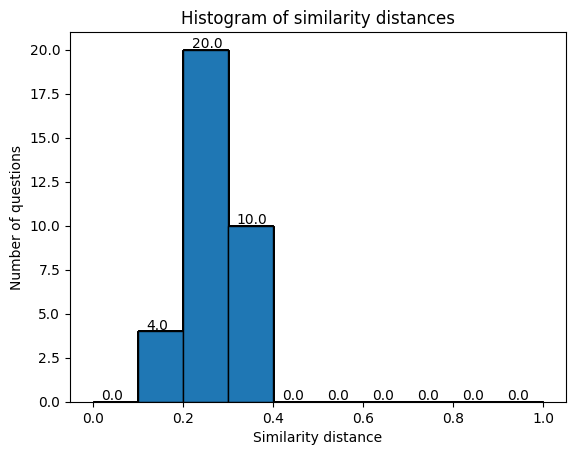

In [5]:
all_pairs = []
counter = 0
for email_name in emails:
    email = data_answers["results"][email_name]
    for question in email:
        sim_distance = question["total_sim_distance"]
        all_pairs.append((counter, sim_distance))
        counter += 1
        
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.hist([pair[1] for pair in all_pairs], bins=bins, edgecolor='black')
plt.xlabel("Similarity distance")
plt.ylabel("Number of questions")
plt.title("Histogram of similarity distances")
# put on number of questions on top of each bar
for i in range(len(bins) - 1):
    plt.text(bins[i]+ 0.02, 0.1+plt.hist([pair[1] for pair in all_pairs], bins=bins, edgecolor='black')[0][i], 
             str(plt.hist([pair[1] for pair in all_pairs], bins=bins, edgecolor='black')[0][i]))
    
plt.show()

        

### Gold answer vs predicted answer

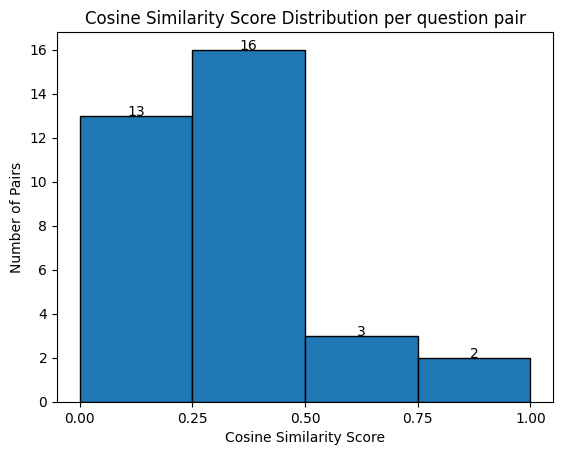

In [6]:
all_pairs = []

for email_name in data_answers["results"]:
    email = data_answers["results"][email_name]
    for question in email:
        generated_answer = question["generated_answer"]
        gold_answer = question["gold_answer"]
        
        if len(generated_answer) == 0 or len(gold_answer) == 0:
            continue
          
        simalirity_score = compare(generated_answer, gold_answer)
        all_pairs.append({
            "generated_answer": generated_answer,
            "gold_answer": gold_answer,
            "score": simalirity_score
        })
        
bins = [0, 0.25, 0.5, 0.75, 1]

counts, _, _ = plt.hist(
    [pair["score"] for pair in all_pairs],
    bins=bins,
    edgecolor='black',
)

plt.title("Cosine Similarity Score Distribution per question pair")
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Number of Pairs")
plt.xticks(bins)

for i, v in enumerate(counts):
    plt.text(bins[i] + 0.125, v, f"{int(v)}", ha='center')
    
plt.show()
  

### Length of the answers

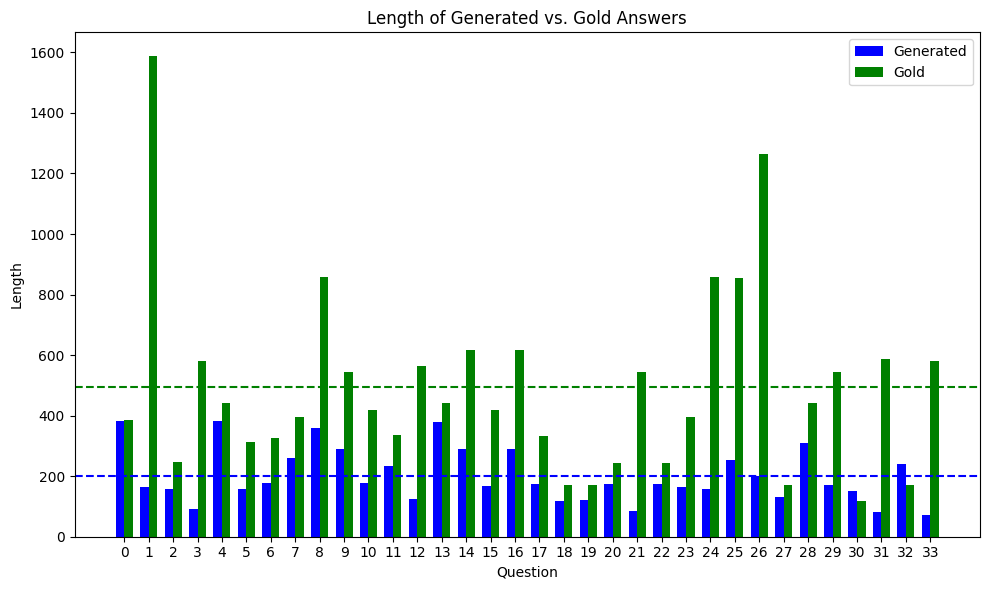

In [7]:
all_pairs = []

counter = 0
for email_name in data_answers["results"]:
    email = data_answers["results"][email_name]
    for question in email:
        generated_answer = question["generated_answer"]
        all_pairs.append({
            "question": counter,
            "length_generated": len(generated_answer),
            "length_gold": len(question["gold_answer"])
        })
        counter += 1
        

# Extract data
questions = [pair["question"] for pair in all_pairs]
lengths_generated = [pair["length_generated"] for pair in all_pairs]
lengths_gold = [pair["length_gold"] for pair in all_pairs]

# Set the width for the bars
bar_width = 0.35

# Manually set the positions for the bars
index = range(len(questions))
generated_positions = [i for i in index]
gold_positions = [i + bar_width for i in index]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(generated_positions, lengths_generated, bar_width, label='Generated', color='b')
plt.bar(gold_positions, lengths_gold, bar_width, label='Gold', color='g')

# Add labels, title, and legend
plt.xlabel('Question')
plt.ylabel('Length')
plt.title('Length of Generated vs. Gold Answers')
plt.xticks([i + bar_width / 2 for i in index], questions)
plt.legend()

# average length of generated answers
average_generated = sum(lengths_generated) / len(lengths_generated)
average_gold = sum(lengths_gold) / len(lengths_gold)

# Add a horizontal line for the average length of generated answers
plt.axhline(y=average_generated, color='b', linestyle='--', label='Average Length Generated')

# Add a horizontal line for the average length of gold answers
plt.axhline(y=average_gold, color='g', linestyle='--', label='Average Length Gold')

# Display the plot
plt.tight_layout()
plt.show()


# Time

### Time per question

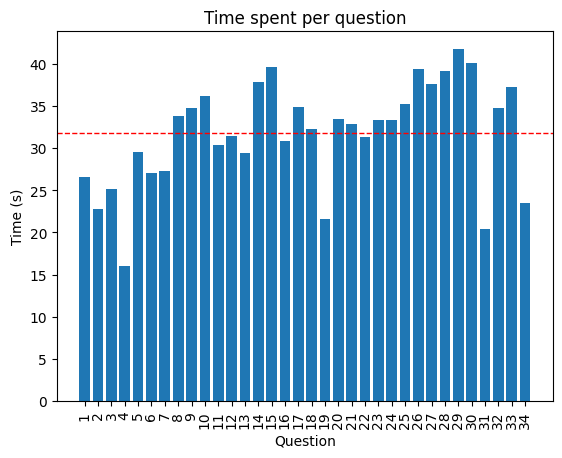

In [8]:
time_per_question = []
time_per_email = {}
counter = 1

for i, email_name in enumerate(data_answers["results"]):
    email = data_answers["results"][email_name]
    total_time = 0
    for question in email:
        total_time += question["time"]
        time_per_question.append({ "question": counter, "time": question["time"]})
        counter += 1
        
    time_per_email[i] = total_time
    
time_per_question = sorted(time_per_question, key=lambda x: x["time"], reverse=True)
# sort by index
time_per_email = sorted(time_per_email.items(), key=lambda x: x[0])

avg_time_per_question = sum([x["time"] for x in time_per_question]) / len(time_per_question)
avg_time_per_email = sum([x[1] for x in time_per_email]) / len(time_per_email)

plt.bar([x["question"] for x in time_per_question], [x["time"] for x in time_per_question])
plt.axhline(avg_time_per_question, color='r', linestyle='dashed', linewidth=1)
plt.xticks(rotation=90)
plt.xlabel("Question")
plt.ylabel("Time (s)")
plt.title("Time spent per question")
plt.xticks(range(1, len(time_per_question) + 1))
plt.show()
    

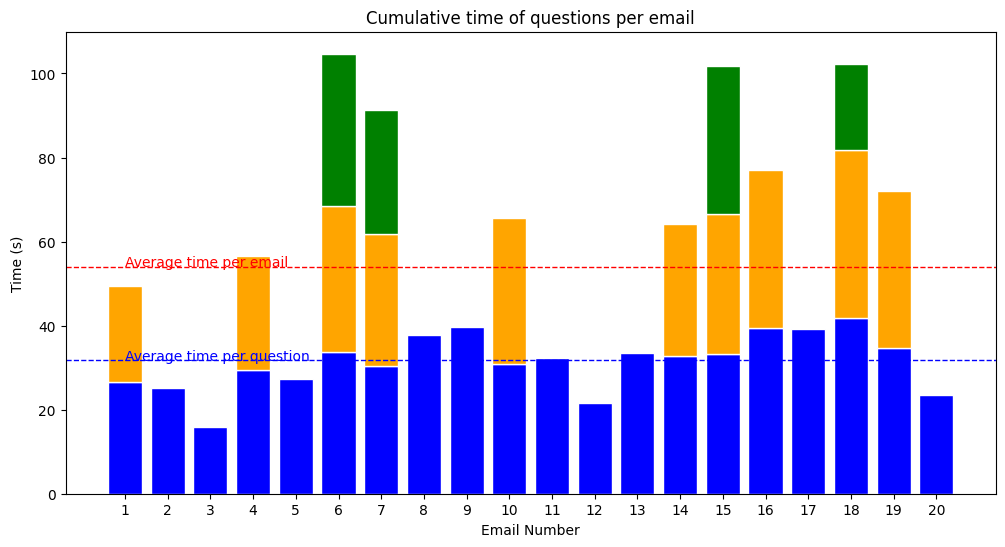

In [9]:
import matplotlib.pyplot as plt

cumulative_times = []  # This will store the time spent on each question for each email

for email_name in data_answers["results"]:
    email = data_answers["results"][email_name]
    email_times = [question["time"] for question in email]
    cumulative_times.append(email_times)


avg_time_per_email = sum([sum(email_times) for email_times in cumulative_times]) / len(cumulative_times)

# Plot cumulative time per email with stacked bars
plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green', 'purple', 'red', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, email_times in enumerate(cumulative_times):
    bottom = 0
    for j, time in enumerate(email_times):
        plt.bar(i, time, bottom=bottom, color=colors[j % len(colors)], edgecolor='white')
        bottom += time

plt.axhline(avg_time_per_email, color='r', linestyle='dashed', linewidth=1)
# name the axhline
plt.text(0, avg_time_per_email, "Average time per email", color='r')

plt.axhline(avg_time_per_question, color='b', linestyle='dashed', linewidth=1)
plt.text(0, avg_time_per_question, "Average time per question", color='b')

# Set x-ticks to numerical indices starting from 1
plt.xticks(range(len(cumulative_times)), range(1, len(cumulative_times) + 1))
plt.xlabel("Email Number")
plt.ylabel("Time (s)")
plt.title("Cumulative time of questions per email")
plt.show()
